In [46]:
import numpy as np
from matplotlib import pyplot as plt, ticker as mticker
from scipy.sparse import csr_matrix
import matplotlib as mpl
from scipy.integrate import quad, simpson
from numpy.linalg import solve, inv
from scipy.sparse.linalg import bicg
from scipy.sparse import csr_matrix
from tqdm.auto import tqdm, trange
import numba
from scipy.integrate import solve_ivp

sys.path.append('../Numerical_methods')
from matrix_calculator import A_matrix


# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}
mpl.rc('font', **font)

In [47]:
N = 5001
r_i = 0.05
r_f = 100
r = np.linspace(r_i, r_f, N)
Δr = r[1] - r[0]
Δt = 0.01
print(Δr, Δt)

0.019989999999999994 0.01


In [48]:
# Inital surface density:
def Σ_initial(x, γ = 1):
    return (3 * np.pi * x**γ)**(-1) * np.exp(-x**(2 - γ))

C = 1 / quad(Σ_initial, r_i, r_f)[0]

def Σ_initial_norm(x, γ = 1):
    return C * Σ_initial(x, γ)

# Analytical soltuion:
def Σ(r, T, γ = 1):
    not_norm = lambda r : (3 * np.pi * r**γ)**(-1) * T**(-(5/2 - γ) / (2 - γ)) * np.exp(-r**(2 - γ) / T)
    #C = 1 / quad(not_norm, x_i, x_f)[0]
    return C * not_norm(r)

In [49]:
quad(lambda r: Σ(r, 1), r_i, r_f)[0]

1.0

$$\partial_t\Sigma=\frac{21}{2}\partial_r\Sigma + 3r \partial_r^2\Sigma + \frac{9}{2r}\Sigma$$
$$\Rightarrow \Sigma(t+Δt) = Σ + Δt\left[\frac{21}{2}\partial_r\Sigma + 3r \partial_r^2\Sigma + \frac{9}{2r}\Sigma\right]$$
$$\Rightarrow \left[1 - \Delta t\left(\frac{21}{2}\partial_r + 3r \partial_r^2\right)\right]\Sigma(t+\delta t)
= \Sigma + Δt \frac{9}{2r} \Sigma$$
### *Solving $Af=b$*

In [50]:
D2 = A_matrix(4, 2, N) / Δr**2
D1 = A_matrix(4, 1, N) / Δr

In [51]:
A = np.identity(N) - Δt * (np.diag(21/2 * np.ones(N)) @ D1 + np.diag(3*r * np.ones(N)) @ D2)
sA = csr_matrix(A)

@numba.njit
def make_b(Σ):
    return Σ + Δt * 9 / (2 * r) * Σ 

In [52]:
γ = 1
t_s = (3 * (2 - γ)**2)**(-1)
print(t_s)

t_func = lambda T, ts: (T - 1) * ts
T_func = lambda t, ts: t / ts + 1

t_func(8, t_s)

0.3333333333333333


2.333333333333333

In [53]:
t = np.arange(0, 3 + Δt, Δt)
steps = trange(len(t))

Σ0 = Σ_initial_norm(r)
sol_nobound = []

for step in steps:
    b = make_b(Σ0)
    res, info = bicg(sA, b, x0 = Σ0)
    sol_nobound.append(res)
    Σ0 = res

100%|██████████| 301/301 [00:28<00:00, 10.54it/s]


In [54]:
T_func(t, t_s)
T_plot = np.array([1, 2, 4, 8])
i_t = []
for T in T_plot:
    i_t.append(np.argmin(abs(T_func(t, t_s) - T)))
i_t
color = ['blue', 'green', 'red', 'orange']

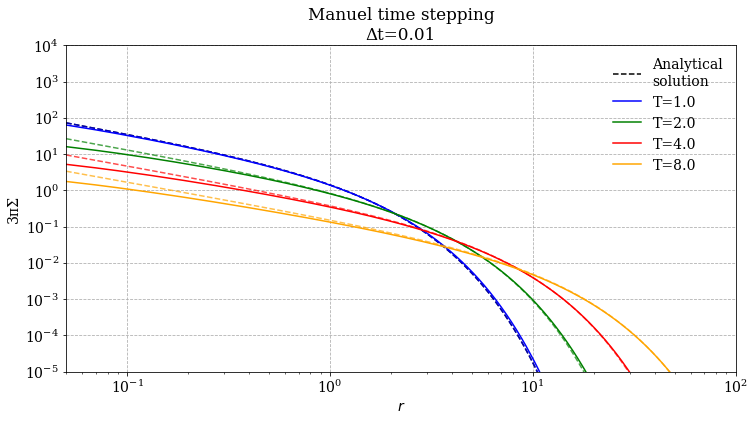

In [55]:
fig, axs = plt.subplots(figsize = (12,6))
plt.grid(ls='--')

axs.loglog(r, 3 * np.pi * Σ_initial_norm(r), label = 'Analytical\nsolution', ls='--', c= 'black')

for i, col in zip(i_t, color):
    axs.loglog(r, 3 * np.pi * sol_nobound[i], label = f'T={T_func(t[i], t_s):1.1f}', c = col)
    axs.loglog(r, 3 * np.pi * Σ(r, T_func(t[i], t_s)), c = col, ls='--', alpha = 0.7)


axs.set(xlabel='$r$', ylabel='3πΣ', ylim = (1e-5, 1e4), xlim = (r_i, r_f), title = f'Manuel time stepping\nΔt={Δt}',
yticks = np.logspace(-5, 4, 10), xticks = np.logspace(-1, 2, 4));
axs.legend(frameon = False)

### Gound for boundary conditions - how to impose $\partial_r(r^{3/2}\Sigma)=0$ ?

In [56]:
'''Σ_i = Σ_initial_norm(r)

A = np.identity(N) - Δt * (np.diag(21/2 * np.ones(N)) @ D1 + np.diag(3*r * np.ones(N)) @ D2)

b = Σ_i + Δt * 9 / (2 * r) * Σ_i 

A[0] = 0
A[0, 0] = 1
A[-1] = 0
A[-1, 1] = 1
sA = csr_matrix(A)

SyntaxError: EOF while scanning triple-quoted string literal (Temp/ipykernel_18000/3663303870.py, line 11)

In [ ]:
'''t = np.arange(0, 1 + Δt, Δt)
steps = trange(len(t))

Σ0 = Σ_initial(r)
sol = []

for step in steps:
    b = make_b(Σ0)
    res, info = bicg(sA, b, x0 = Σ0)
    sol.append(res)
    Σ0 = res'''

't = np.arange(0, 1 + Δt, Δt)\nsteps = trange(len(t))\n\nΣ0 = Σ_initial(r)\nsol = []\n\nfor step in steps:\n    b = make_b(Σ0)\n    res, info = bicg(sA, b, x0 = Σ0)\n    sol.append(res)\n    Σ0 = res'

In [ ]:
'''T_func(t, t_s)
T_plot = np.array([1, 2, 4, 8])
i_t = []
for T in T_plot:
    i_t.append(np.argmin(abs(T_func(t, t_s) - T)))
i_t'''

[0, 33, 100, 100]

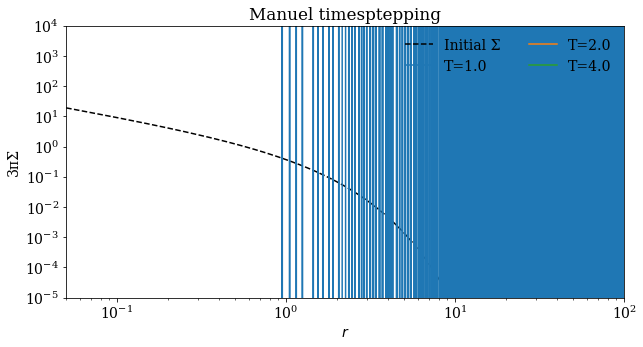

In [ ]:
'''fig, axs = plt.subplots(figsize = (10,5))

axs.loglog(r, 3 * np.pi * Σ_initial(r), label = 'Initial Σ', ls='--', c= 'black')

for i in i_t[:-1]:
    axs.loglog(r, 3 * np.pi * sol[i], label = f'T={T_func(t[i], t_s):1.1f}')
    

axs.set(xlabel='$r$', ylabel='3πΣ', ylim = (1e-5, 1e4), xlim = (r_i, r_f), title = 'Manuel timesptepping',
yticks = np.logspace(-5, 4, 10), xticks = np.logspace(-1, 2, 4));
axs.legend(frameon = False, ncol = 2)'''